In [1]:
import os, json

import tensorflow as tf
import tensorflow_probability as tfp
tfd = tfp.distributions
tfk = tf.keras
tfl = tf.keras.layers
tfs = tf.summary

import numpy as np

from tqdm import tqdm_notebook as tqdm

import matplotlib.pyplot as plt

In [12]:
class ManifoldEncoder(tfl.Layer):
    
    def __init__(self,
                 latent_dim=64,
                 name="manifold_encoder",
                 **kwargs):
        
        # Initialise superclass
        super(ManifoldEncoder, self).__init__(name=name, **kwargs)
        
        # Set fields
        self.latent_dim = latent_dim
        
        # --------------------------------------------------------------
        # Define layers
        # --------------------------------------------------------------
        
        self.layers = [
            tfl.Reshape((28, 28, 1), input_shape=(28, 28)),
            tfl.Conv2D(filters=64,
                       kernel_size=(5, 5),
                       strides=2,
                       padding="same",
                       name="encoder_conv1"),
            tf.nn.leaky_relu,
            tfl.Conv2D(filters=128,
                       kernel_size=(5, 5),
                       strides=2,
                       padding="same",
                       use_bias=False,
                       name="encoder_conv2"),
            tfl.BatchNormalization(),
            tf.nn.leaky_relu,
            tfl.Flatten(),
            tfl.Dense(units=1024,
                      use_bias=False,
                      name="encoder_linear1"),
            tfl.BatchNormalization(),
            tf.nn.leaky_relu
        ]
        
        self.loc_head = tfl.Dense(units=self.latent_dim,
                                  name="encoder_loc_head")
        self.log_scale_head = tfl.Dense(units=self.latent_dim,
                                        name="encoder_scale_head")
        
    def call(self, inputs, training=True):
        
        activations = inputs
        
        for layer in self.layers:
            
            if isinstance(layer, tfl.BatchNormalization):
                activations = layer(activations, training=training)
                
            else:
                activations = layer(activations)
            
        loc = self.loc_head(activations)
        scale = tf.nn.softplus(self.log_scale_head(activations))
        
        self.posterior = tfd.Normal(loc=loc, scale=scale)
        
        return self.posterior.sample()
    
    
class ManifoldDecoder(tfl.Layer):
    
    def __init__(self, 
                 name="manifold_decoder",
                 **kwargs):
        
        # Initialise superclass
        super(ManifoldDecoder, self).__init__(name=name, **kwargs)
        
        # Hyperparams
        self.log_gamma = tf.Variable(0., "log_gamma")
        
        # --------------------------------------------------------------
        # Define layers: reverse of a ManifoldEncoder
        # --------------------------------------------------------------
        self.layers = [
            tfl.Dense(units=1024),
            tf.nn.leaky_relu,
            tfl.Dense(units=7 * 7 * 128,
                      use_bias=False),
            tfl.BatchNormalization(),
            tf.nn.leaky_relu,
            tfl.Reshape((7, 7, 128)),
            tfl.Conv2DTranspose(filters=64,
                                kernel_size=(5, 5),
                                strides=2,
                                padding="same",
                                use_bias=False),
            tfl.BatchNormalization(),
            tf.nn.leaky_relu,
            tfl.Conv2DTranspose(filters=1,
                                kernel_size=(5, 5),
                                padding="same",
                                strides=2)
        ]
        
    def call(self, inputs, training=True):
        
        activations = inputs
        
        for layer in self.layers:
            
            if isinstance(layer, tfl.BatchNormalization):
                activations = layer(activations, training=training)
                
            else:
                activations = layer(activations)
            
        self.likelihood = tfd.Normal(loc=activations,
                                     scale=tf.exp(self.log_gamma))
        
        return tf.nn.sigmoid(activations)
    

class ManifoldVAE(tfk.Model):
    
    def __init__(self,
                 latent_dim=64,
                 name="manifold_vae",
                 **kwargs):
        
        super(ManifoldVAE, self).__init__(name=name,
                                          **kwargs)
        
        # Define stuff
        self.latent_dim = latent_dim
        self.prior = tfd.Normal(loc=tf.zeros(latent_dim),
                                scale=tf.ones(latent_dim))
        
        # Define blocks
        self.encoder = ManifoldEncoder(latent_dim=self.latent_dim)
        self.decoder = ManifoldDecoder()
        
    @property 
    def posterior(self):
        return self.encoder.posterior
    
    @property
    def likelihood(self):
        return self.decoder.likelihood
    
    @property
    def log_gamma(self):
        return self.decoder.log_gamma
    
    @property
    def kl_divergence(self):
        return tfd.kl_divergence(self.posterior, self.prior)
    
    @property
    def log_prob(self):
        return tf.reduce_sum(self._log_prob)
         
    def call(self, inputs, training=True):
        
        latents = self.encoder(inputs, training=training)
        reconstruction = self.decoder(latents, training=training)
        
        self._log_prob = self.likelihood.log_prob(inputs[..., tf.newaxis])
        
        return reconstruction

In [13]:
def mnist_input_fn(data, batch_size=256, shuffle_samples=5000):
    dataset = tf.data.Dataset.from_tensor_slices(data)
    dataset = dataset.shuffle(shuffle_samples)
    dataset = dataset.map(mnist_parse_fn)
    dataset = dataset.batch(batch_size)

    return dataset


def mnist_parse_fn(data):
    return tf.cast(data, tf.float32) / 255.


optimizers = {
    "sgd": tfk.optimizers.SGD,
    "adam": tfk.optimizers.Adam,
}

In [14]:
MODEL_DIR = "/tmp/2-stage-vae-v3/"

config = {
        "num_training_examples": 60000,
        "batch_size": 250,
        "num_epochs": 10,
        "num_epochs_stage_2": 5,
        
        "beta1": 0.1,
        "beta2": 0.1,
        "warmup": 10.,
        
        "learning_rate": 1e-3,
        
        "optimizer": "adam",
        
        "checkpoint_name": "_ckpt",
        "log_freq": 100,
    }

In [16]:
num_batches = config["num_training_examples"] // config["batch_size"] + 1


print("Configuration:")
print(json.dumps(config, indent=4, sort_keys=True))

# ==========================================================================
# Load dataset
# ==========================================================================

((train_data, _),
 (eval_data, _)) = tf.keras.datasets.mnist.load_data()

# ==========================================================================
# Create model
# ==========================================================================

vae = ManifoldVAE(latent_dim=64)

optimizer = optimizers[config["optimizer"]](config["learning_rate"])
             
# ==========================================================================
# Train the model
# ==========================================================================

def train(log_freq=10):
    
    beta = config["beta1"]

    for epoch in range(1, config["num_epochs"] + 1):

        dataset = mnist_input_fn(data=train_data,
                                batch_size=config["batch_size"])

        with tqdm(total=num_batches) as pbar:
            for batch in dataset:

                with tf.GradientTape() as tape:

                    output = vae(batch, training=True)

                    kl = vae.kl_divergence
                    total_kl = tf.reduce_sum(kl)

                    log_prob = vae.log_prob

                    warmup_coef = tf.minimum(1., optimizer.iterations.numpy() / (config["warmup"] * num_batches))

                    # negative ELBO
                    loss = total_kl - beta * warmup_coef * log_prob 

                    output = tf.cast(output, tf.float32)

                gradients = tape.gradient(loss, vae.trainable_variables)
                optimizer.apply_gradients(zip(gradients, vae.trainable_variables))
                
                # Log stuff
                if tf.equal(optimizer.iterations % log_freq, 0):
                    # Add tensorboard summaries
                    tfs.scalar("Loss", loss, step=optimizer.iterations)
                    tfs.scalar("Total_KL", total_kl, step=optimizer.iterations)
                    tfs.scalar("Max_KL", tf.reduce_max(kl), step=optimizer.iterations)
                    tfs.scalar("Log-Probability", log_prob, step=optimizer.iterations)
                    tfs.scalar("Warmup_Coef", warmup_coef, step=optimizer.iterations)
                    tfs.scalar("Gamma-x", tf.exp(vae.log_gamma), step=optimizer.iterations)
                    tfs.image("Reconstruction", output, step=optimizer.iterations)
                    

                # Update the progress bar
                pbar.update(1)
                pbar.set_description("Epoch {}, ELBO: {:.2f}".format(epoch, loss))

train_summary_writer = tfs.create_file_writer(MODEL_DIR + '/summaries/train')            

with train_summary_writer.as_default():
    train(log_freq=10)

print("First Stage Training Complete!")

Configuration:
{
    "batch_size": 250,
    "beta1": 0.1,
    "beta2": 0.1,
    "checkpoint_name": "_ckpt",
    "learning_rate": 0.001,
    "log_freq": 100,
    "num_epochs": 10,
    "num_epochs_stage_2": 5,
    "num_training_examples": 60000,
    "optimizer": "adam",
    "warmup": 10.0
}



First Stage Training Complete!


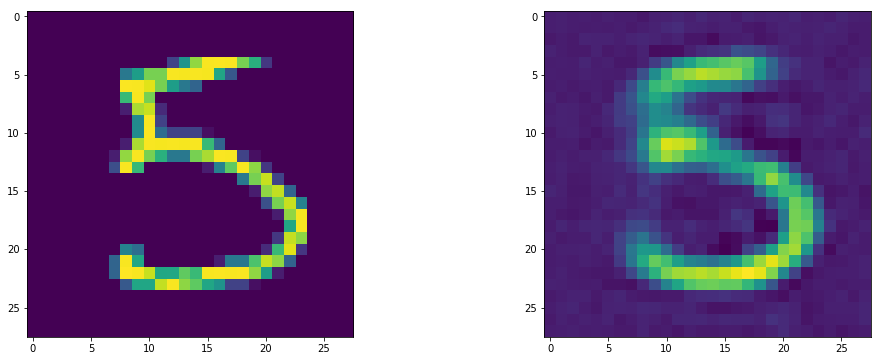

In [41]:
idx = 15

im = eval_data[idx:idx + 1]
z = vae.encoder(mnist_parse_fn(im), training=False)
# z = tf.ones((1, 64))
# z = vae.posterior.sample()

rec_im = vae.decoder(z, training=False)

plt.figure(figsize=(17, 6))
plt.subplot(121)
plt.imshow(im[0])

plt.subplot(122)
plt.imshow(tf.squeeze(rec_im))

plt.show()